## Neural Style Transfer using Pytorch and VGG19

- src:  MLSlayer/Neural-Style-Transfer-Tutorial-Guide-Pytorch-Comprehensive 
- Some images: D. Foster's Book: Generative Deep Learning

## Feature Map Comparison by Gram Matrix

- Suppose the features from 3 images A, B, and C
![feature map example](../figures/features_example.png)

- Gram matrix: $m_{ij} = f_i \cdot f_j$
![gram matrices](../figures/gram_matrices.png)

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch as t
import torch.nn.functional as F
from torchvision import transforms, models

Here we load two images, one for styling and one for the content to style on

In [3]:
tfms = transforms.Compose([transforms.Resize((256, 256), Image.BICUBIC), transforms.ToTensor()])
device = t.device('cuda' if t.cuda.is_available() else 'cpu')

style_img = tfms(Image.open('../data/style.jpg'))[None].to(device, t.float)
content_img = tfms(Image.open('../data/content.jpg'))[None].to(device, t.float)

`transforms.ToTensor()` 
- transforms a PIL image to torch tensor 
- scale the pixel values to [0,1].
- make extra dimension for batch

In [4]:
style_img.shape, style_img.dtype

(torch.Size([1, 3, 256, 256]), torch.float32)

In [5]:
def imshow(tensor, title=None):
#    plt.imshow(transforms.ToPILImage()(tensor.cpu()[0]))
    plt.imshow(tensor.cpu()[0].permute(1,2,0).numpy())
    plt.title(title)
    plt.show()

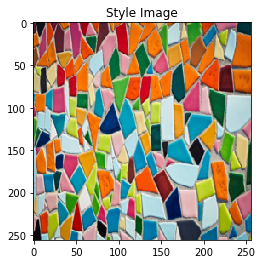

In [5]:
imshow(style_img, title='Style Image')

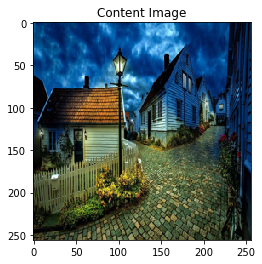

In [6]:
imshow(content_img, title='Content Image')

**ContentLoss**
The contents of the two images are compared by MSE Loss. Typical.
- Note that after an execution of this layer, the result is recorded in `self.loss`

In [7]:
class ContentLoss(nn.Module):
    def __init__(self, content_target):
        super(ContentLoss, self).__init__()
        self.content_target = content_target

    def forward(self, x):
        self.loss = F.mse_loss(x, self.content_target, reduction='mean')
        return x


**StyleLoss** is measured by MSE between Gram matrices.

In [8]:
class StyleLoss(nn.Module):
    def __init__(self, style_target):
        super(StyleLoss, self).__init__()
        self.style_target = self.gram_matrix(style_target).detach()
        
    def gram_matrix(self, x):
        b, c, h, w = x.shape
        features = x.view(b * c, w * h)
        g_matrix = t.mm(features, features.t())
        return g_matrix.div(b * c * w * h)

    def forward(self, x):
        gram_prod = self.gram_matrix(x)
        self.loss = F.mse_loss(gram_prod, self.style_target, reduction='mean')
        return x


VGG is trained for the normalized images. For each channel pixels values are transformed by:
$$
    I' = \frac{I - \mu}{\sigma}
$$

In [9]:
class Vgg19Norm(nn.Module):
    def __init__(self):
        super(Vgg19Norm, self).__init__()
        self.mean = t.tensor([[[0.485]], [[0.456]], [[0.406]]]).to(device)
        self.std = t.tensor([[[0.229]], [[0.224]], [[0.225]]]).to(device)

    def forward(self, img):
        return (img - self.mean) / self.std


vgg19 has three upper layers: features, avgpool, classifier. We need only the first `features` layer for neural style transfer.

In [10]:
vgg19 = models.vgg19(pretrained=True)
vgg19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [11]:
for i, layer in enumerate(vgg19.features.children()):
    print(f'{i}: {layer.__class__.__name__}')

0: Conv2d
1: ReLU
2: Conv2d
3: ReLU
4: MaxPool2d
5: Conv2d
6: ReLU
7: Conv2d
8: ReLU
9: MaxPool2d
10: Conv2d
11: ReLU
12: Conv2d
13: ReLU
14: Conv2d
15: ReLU
16: Conv2d
17: ReLU
18: MaxPool2d
19: Conv2d
20: ReLU
21: Conv2d
22: ReLU
23: Conv2d
24: ReLU
25: Conv2d
26: ReLU
27: MaxPool2d
28: Conv2d
29: ReLU
30: Conv2d
31: ReLU
32: Conv2d
33: ReLU
34: Conv2d
35: ReLU
36: MaxPool2d


![VGG19 architecture](../figures/vgg19.png)
Now after we loaded the vgg19 model, we are going to make our model out of that. First thing we did is add the 
normalization layer, then we are going to keep adding from the vgg model to our model, along with 
our corresponding content and style losses per layer, then slice off the layers after our last content and style 
loss layer

In [12]:
# the content_layers and style_laers are chosen somehow.
content_layers = ['Conv2d_4']
style_layers = ['Conv2d_1', 'Conv2d_2', 'Conv2d_3', 'Conv2d_4', 'Conv2d_5']
style_layers = ['Conv2d_9', 'Conv2d_10', 'Conv2d_3', 'Conv2d_4', 'Conv2d_5']

def make_model():
    # load pre-trained vgg19 model
    vgg19_features = models.vgg19(pretrained=True).features.to(device).eval()
   
    content_losses, style_losses = [], []

    # the first layer is normalization
    model = nn.Sequential(Vgg19Norm())

    # now re-arrange the layers to insert content/style loss layers
    # insert layers of style_loss and contents_loss into the vgg19.features network.
    i = 0
    for layer in vgg19_features.children():
        # print(layer.__class__.__name__)
        if isinstance(layer, nn.Conv2d):
            i += 1
        if isinstance(layer, nn.ReLU):
            layer = nn.ReLU()

        name = f'{layer.__class__.__name__}_{i}'
        model.add_module(name, layer)

        if name in content_layers:
            content_target = model(content_img).detach()
            content_loss = ContentLoss(content_target)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)
            # print(i, 'Content Loss appended: ', content_target.shape)

        if name in style_layers:
            style_target = model(style_img).detach()
            style_loss = StyleLoss(style_target)
            model.add_module(f'style_loss_{i}', style_loss)
            style_losses.append(style_loss)
            # print(i, 'Style Loss appended:', style_target.shape)

    # remove (trim off) un-used layers among vgg19.features. 
    # You may keep them but will take computation resource.

    for i, e in reversed(list(enumerate(model))):
        if isinstance(e, (ContentLoss, StyleLoss)):
            break
    model = model[:i + 1]

    return model, content_losses, style_losses
#

In [13]:
model, content_losses, style_losses = make_model()
# print out the final network
for i, layer in enumerate(model.children()):
    print(f'{i}  {layer}')

0  Vgg19Norm()
1  Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2  ReLU()
3  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
4  ReLU()
5  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
6  Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7  StyleLoss()
8  ReLU()
9  Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
10  ContentLoss()
11  StyleLoss()
12  ReLU()
13  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
14  Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15  StyleLoss()
16  ReLU()
17  Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
18  ReLU()
19  Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
20  ReLU()
21  Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
22  ReLU()
23  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
24  Conv2d(256, 512, kernel_size=

In [14]:
# we pass in the output_img as something you directly take the gradient on
# in order to make it something that will give you small content losses and style losses
# when passing it through the network. That gradient for the output_img
# is computed from backward on the style loss and content loss

## Optimization with LBFGS

Now the optimiztion update is performed on the output_image only. Since we are using a pre-trained network, we don't have train it again - it is meaningless. The parameters (pixel values) of output_img is updated.
- Look carefully at the `optimizer` declaration. 

In [15]:
output_img = content_img.clone().requires_grad_()
print(output_img.shape, output_img.requires_grad)
#
optimizer = t.optim.LBFGS([output_img])

torch.Size([1, 3, 256, 256]) True


In [16]:
#
i = 0
while i <= 300:
    # LBFGS requires closure
    def closure():
        global i
        output_img.data.clamp_(0, 1)

        optimizer.zero_grad()
        model(output_img)
        style_loss = 0
        content_loss = 0
        
        # here we count in the style and content losses we mentioned at the beginning
        # which were computed and saved from passing through the model
        for sl in style_losses:
            style_loss += sl.loss
        for cl in content_losses:
            content_loss += cl.loss

        # the bigger the style lambda, the less fine grainy details you might lose from the content
        style_lambda = 1000000
        content_lambda = 1
        style_loss *= style_lambda
        content_loss *= content_lambda

        loss = style_loss + content_loss
        loss.backward()

        i += 1
        if i % 50 == 0:
            print('iteration: ', i)
            print(f'style loss : {style_loss.item():.1f}\tcontent loss: {content_loss.item():.1f}\n')

        return loss

    optimizer.step(closure)
    output_img.data.clamp_(0, 1) # restrict pixel values
#

iteration:  50
style loss : 13537.0	content loss: 40.3

iteration:  100
style loss : 5524.1	content loss: 47.9

iteration:  150
style loss : 3156.5	content loss: 52.3

iteration:  200
style loss : 2209.2	content loss: 54.9

iteration:  250
style loss : 1646.2	content loss: 57.0

iteration:  300
style loss : 1316.8	content loss: 58.6



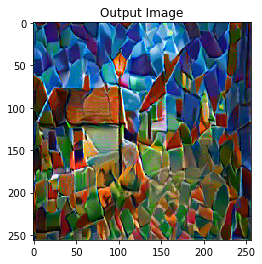

In [17]:
imshow(output_img.detach().cpu(), title='Output Image')
plt.show()

## Optimization with SGD/Adam

In [18]:
def train(output_img,
          model, style_losses, content_losses,
          optimizer,  
          style_lambda=10000, content_lambda=1, epochs=100, verbose=False):
    """ 
    """
    for i in range(epochs+1):
        optimizer.zero_grad()
        model(output_img)
        style_loss = 0
        content_loss = 0

        # here we count in the style and content losses we mentioned at the beginning
        # which were computed and saved from passing through the model
        for sl in style_losses:
            style_loss += sl.loss
        for cl in content_losses:
            content_loss += cl.loss

        # the bigger the style lambda, the less fine grainy details you might lose from the content
        #style_lambda = 10000
        #content_lambda = 1
        style_loss *= style_lambda
        content_loss *= content_lambda

        loss = style_loss + content_loss

        loss.backward()
        optimizer.step()

        output_img.data.clamp_(0, 1) # restrict pixel values
#       output_img.data = t.sigmoid(output_img.data)

        i += 1
        if i % 50 == 0 and verbose:
            print('iteration: ', i)
            print(f'style loss : {style_loss.item():.1f}\tcontent loss: {content_loss.item():.1f}',
                 # output_img.grad[0,0,100,100], output_img.data[0,0,100,100]
                 )

#         if i%100 == 0:
#             import imageio
#             filename = f'nst_output_{i}.png'
#             imageio.imwrite(filename, output_img.detach().cpu()[0].permute(1,2,0).numpy())
#             print('output>> ', filename)
    print('train_loss: ', style_loss.item(), content_loss.item())
    return output_img

input image:  torch.Size([1, 3, 256, 256]) True
train_loss:  111.44261932373047 40.932029724121094


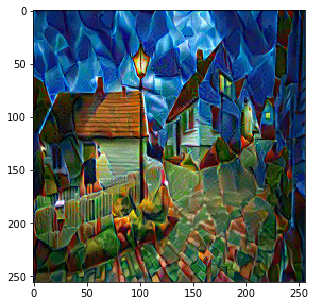

In [19]:
output_img = content_img.clone().requires_grad_()
print('input image: ', output_img.shape, output_img.requires_grad)
#
optimizer = t.optim.SGD([output_img], lr=.01)
#
output_img = train(output_img, model, style_losses, content_losses, optimizer, style_lambda=1E4, content_lambda=1, epochs=300)
#
plt.figure(figsize=(5,5))
plt.imshow(output_img.detach().cpu()[0].permute(1,2,0).numpy())
plt.show()

train_loss:  141.60589599609375 44.29745864868164


Text(0.5, 1.0, 'epochs=300+300')

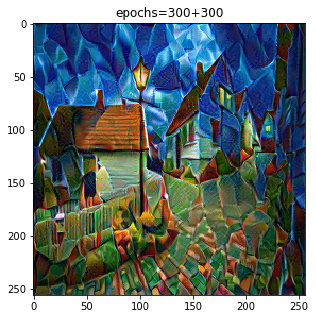

In [20]:
output_img = train(output_img, model, style_losses, content_losses, optimizer, style_lambda=1E4, content_lambda=1, epochs=300)
#
plt.figure(figsize=(5,5))
plt.imshow(output_img.detach().cpu()[0].permute(1,2,0).numpy())
plt.title('epochs=300+300')

train_loss:  43.846717834472656 46.12286376953125


Text(0.5, 1.0, 'epochs=300+300+3000')

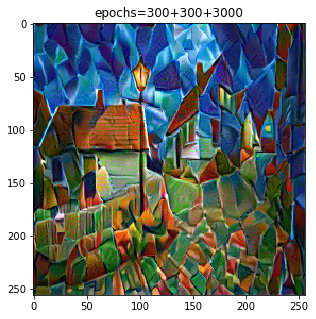

In [21]:
output_img = train(output_img, model, style_losses, content_losses, optimizer, style_lambda=1E4, content_lambda=1, epochs=3000)
#
plt.figure(figsize=(5,5))
plt.imshow(output_img.detach().cpu()[0].permute(1,2,0).numpy())
plt.title('epochs=300+300+3000')

input image:  torch.Size([1, 3, 256, 256]) True
train_loss:  95.0416488647461 0.4622844457626343


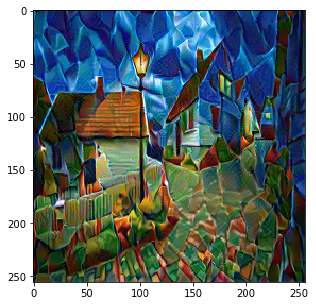

In [22]:
#output_img = t.rand_like(content_img).requires_grad_().to(device)
output_img = content_img.clone().requires_grad_()
print('input image: ', output_img.shape, output_img.requires_grad)
#
optimizer = t.optim.SGD([output_img], lr=0.01)
#
r = train(output_img, model, style_losses, content_losses, optimizer, style_lambda=1E4, content_lambda=.01, epochs=500)
#
plt.figure(figsize=(5,5))
plt.imshow(r.detach().cpu()[0].permute(1,2,0).numpy())

In [23]:

#model, content_losses, style_losses = get_model()
#
lambdas_list = [1E3, 1E4]
epochs_list = [100, 400]
result = []
for style_lambda in lambdas_list:
    for epochs in epochs_list:
        print(style_lambda, epochs)
        # initialize
        output_img = content_img.clone().requires_grad_()
        print('input image: ', output_img.shape, output_img.requires_grad)
        #
        optimizer = t.optim.SGD([output_img], lr=0.1)
        #
        r = train(output_img, model, style_losses, content_losses, optimizer, style_lambda=style_lambda, epochs=epochs)
        #
        #print(r.shape)
        result.append(r.detach().cpu()[0].permute(1,2,0).numpy().copy())
        #print(result[0].shape)

1000.0 100
input image:  torch.Size([1, 3, 256, 256]) True
train_loss:  56.53738021850586 28.58470916748047
1000.0 400
input image:  torch.Size([1, 3, 256, 256]) True
train_loss:  27.105134963989258 27.755361557006836
10000.0 100
input image:  torch.Size([1, 3, 256, 256]) True
train_loss:  3255173.0 1044.4510498046875
10000.0 400
input image:  torch.Size([1, 3, 256, 256]) True
train_loss:  3428016.0 1053.29345703125


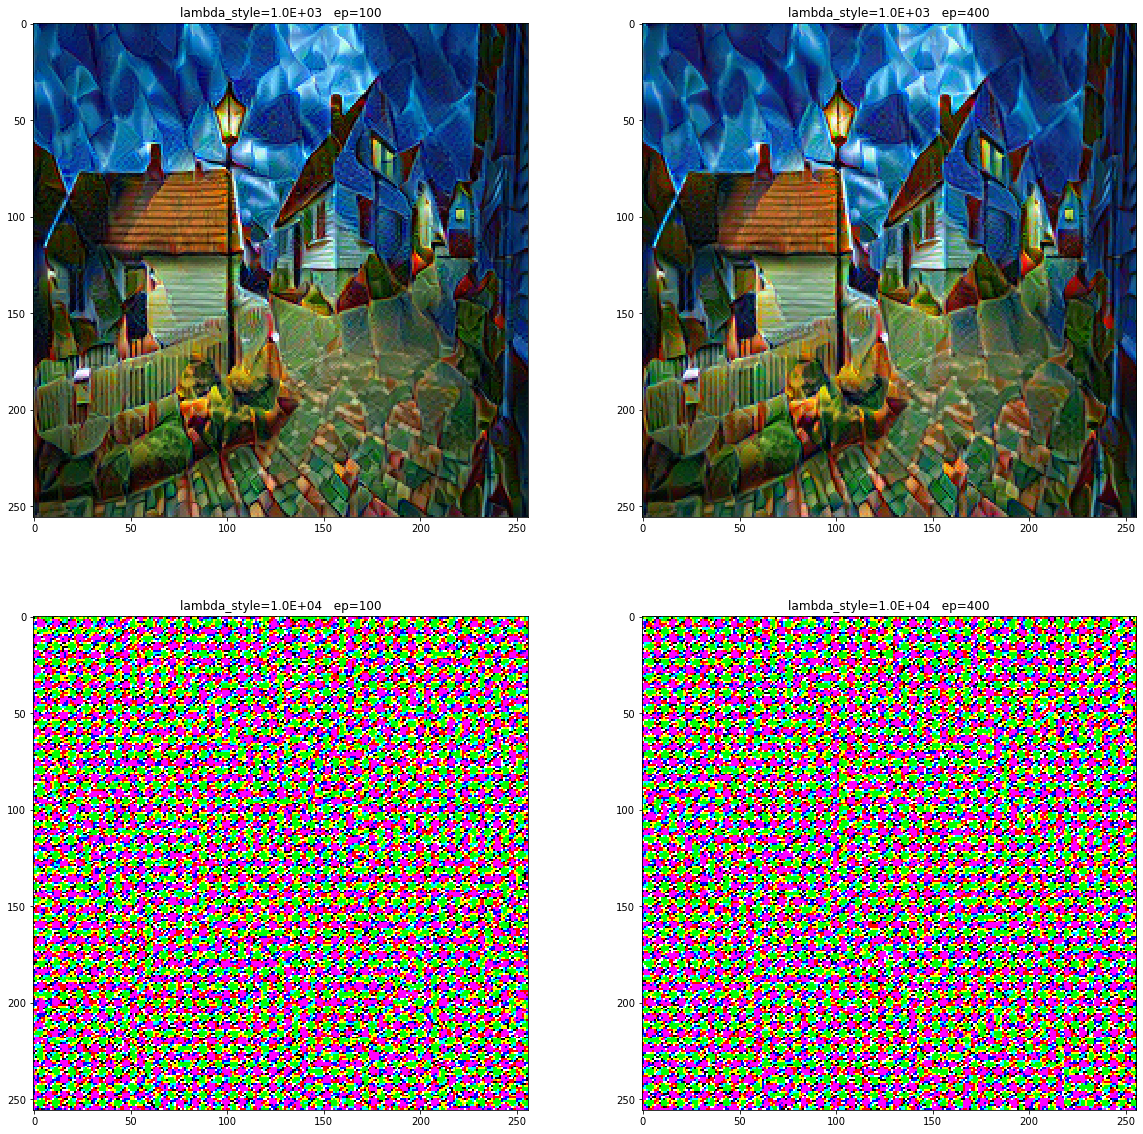

In [24]:
def gi(i):
    print(i.shape, i.dtype)
    return i.detach().cpu()[0].permute(1,2,0).numpy()

fig, axes = plt.subplots(len(lambdas_list), len(epochs_list), figsize=(20,20))
for i, lmda in enumerate(lambdas_list):
    for j, epo in enumerate(epochs_list):
        axes[i][j].imshow(result[j + i*len(epochs_list)])
        axes[i][j].set_title(f'lambda_style={lmda:.1E}   ep={epo}')

End.

---